# 1. Overview
## 1.1 Goal
Try to find the best hyperparameters for the neural network of mutual information between latent vector z and batch vector s. The hyperparameters refers to: n_latent_z: number of nodes in each latent layer for the neural network of mutual information.
, n_layers_z: number of layers for the neural network of mutual information, MineLoss_Scale: the scale parameter for the mutual
information.
## 1.2 Design
Produce 20 combinations for the 3 hyperparameters: n_latent_z: [10, 30], n_layers_z: [3, 10], MineLoss_Scale: [1000, 5000, 10000, 50000, 100000]. The reason to choose 10, and 30 for n_latent_z is that the default value for n_latent_z in the VAE_MINE.py is 5, it is found that n_latent_z=5 has no difference from n_latent_z=1. Therefore, I begin from 10. For MineLoss_Scale, 1000, 5000, 10000, 50000, 100000 are chosen because reconstruction loss could be several thousands, while mutual information is smaller than 1. For each combination of the three hyperparameter, run scVI, and scVI+MINE on built-in pbmc dataset. The split ratio for training and testing set is 6:4.

# 2. Get Data
pbmc dataset is built-in scVI dataset. just use the function PbmcDataset() in scvi.dataset to load the dataset

# 3. Code
The code is in D:/UMelb/PhD_Projects/Project1_Modify_SCVI/code/2019-05-01_Tune_Hyperparameter_For_MineNet.py

# 4. Result and Lab Meeting Discussion
The raw result of Tuning Hyperparameters for MineNet using 20 combinations is stored in D:/UMelb/PhD_Projects/Project1_Modify_SCVI/result/2019-05-01/, and the corresponding summaried result is shown here.
Only n_latent_z=30, n_layers_z=3, MineLoss_Scale=[1000, 5000, 10000, 50000, 100000] is demonstrated in the summrized result
because n_latent_z=30, n_layers_z=3 seems produce most typical result after reviewing all the results of 20 combinations.

## 4.1 Clustering metric results

(0.0, 1.0, 0.0, 1.0)

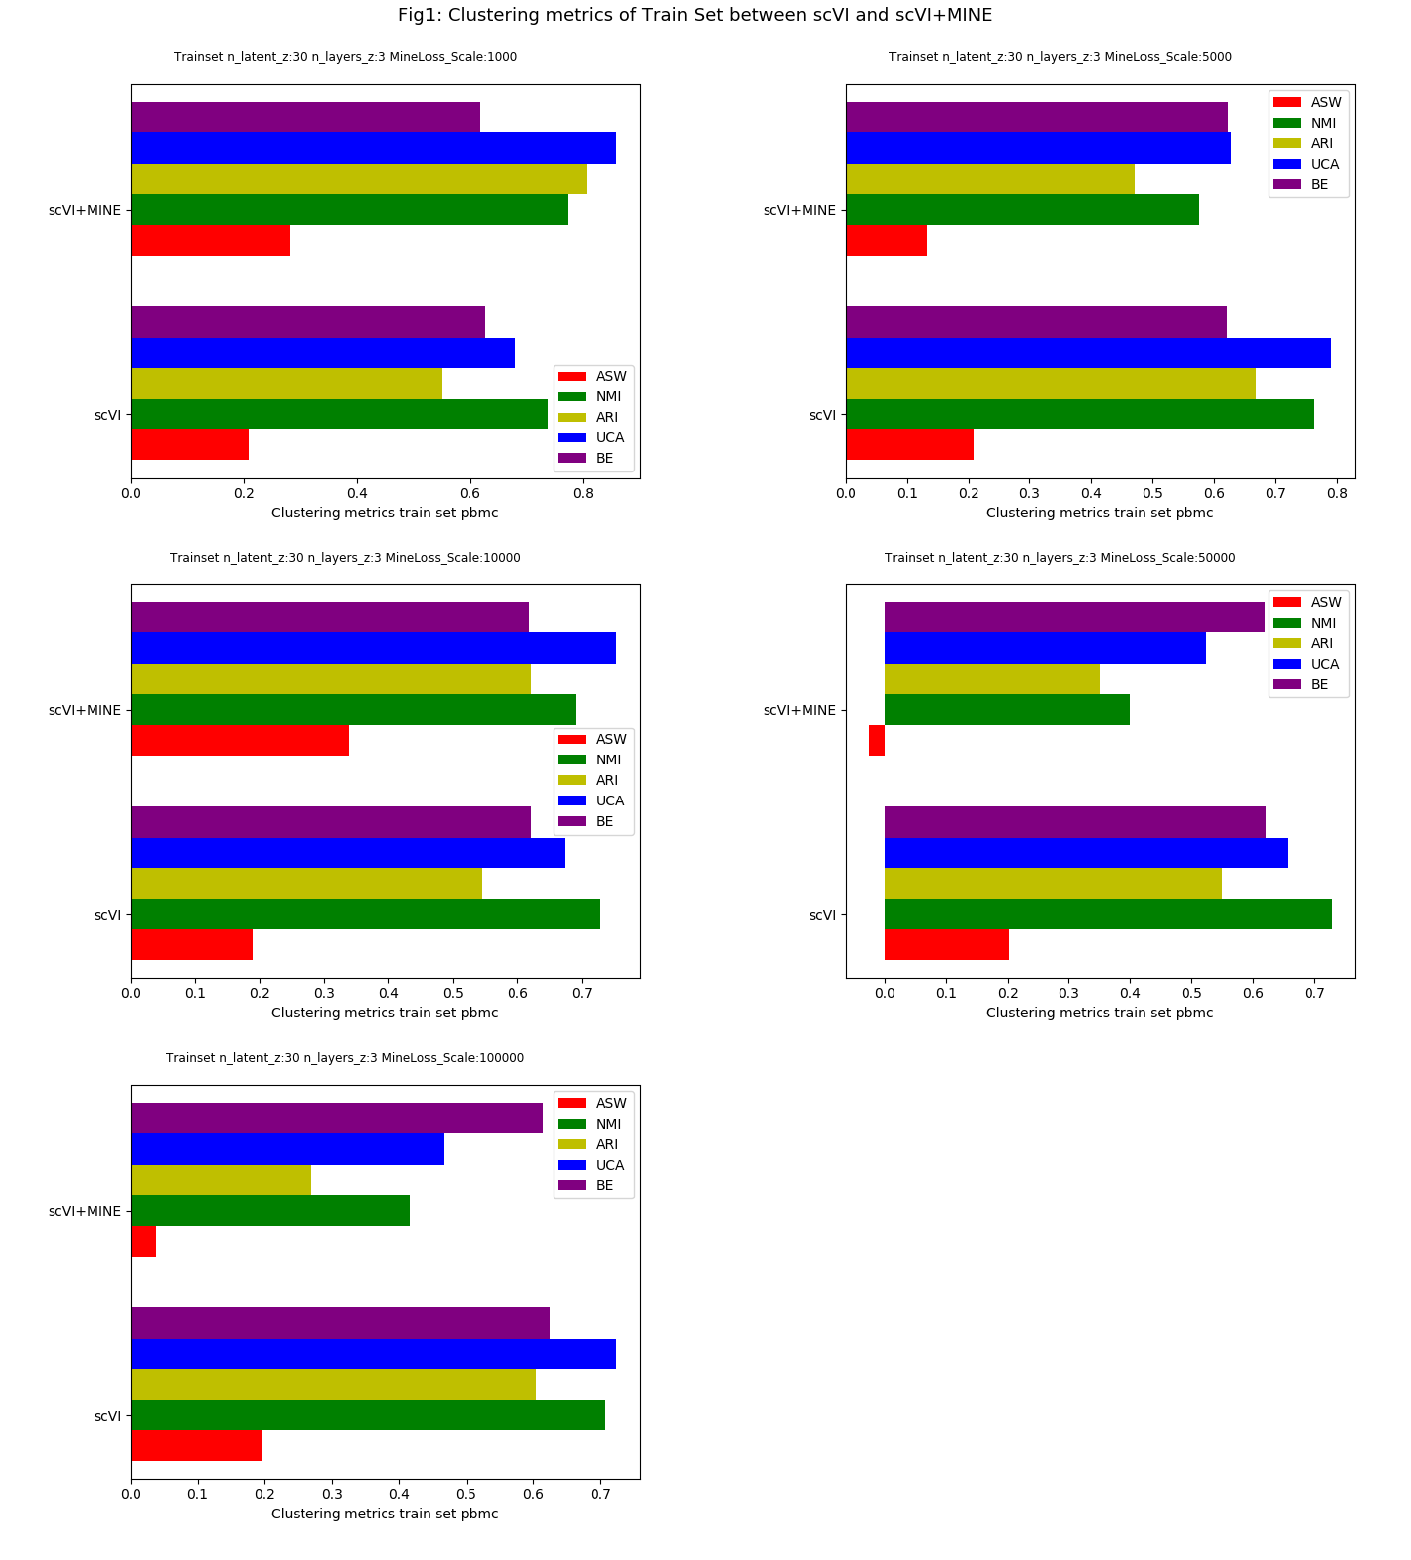

In [71]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

os.chdir('D:\\UMelb\\PhD_Projects\\Project1_Modify_SCVI\\')
images = []
MineLoss_Scales = [1000,5000,10000,50000,100000]
for MineLoss_Scale in MineLoss_Scales:
    img_path = 'result\\2019-05-01\\trainset_clustering_metrics_pbmc_Hidden30_layers3_MineLossScale%s.png'%(MineLoss_Scale)
    images.append(mpimg.imread(img_path))

fig,ax = plt.subplots(3,2,figsize=(20,21))
fig.tight_layout()
columns = 2
for i, image in enumerate(images):
    ax[i//2,i-(i//2)*2] = plt.subplot(len(images) / columns + 1, columns, i + 1)
    ax[i//2,i-(i//2)*2].axis('off')
    ax[i//2,i-(i//2)*2].set_title('Trainset n_latent_z:30 n_layers_z:3 MineLoss_Scale:%s'%(MineLoss_Scales[i]))
    plt.imshow(image)
fig.suptitle('Fig1: Clustering metrics of Train Set between scVI and scVI+MINE', y=1.03, fontsize=18, verticalalignment='top')
ax[-1,-1].axis('off')

(0.0, 1.0, 0.0, 1.0)

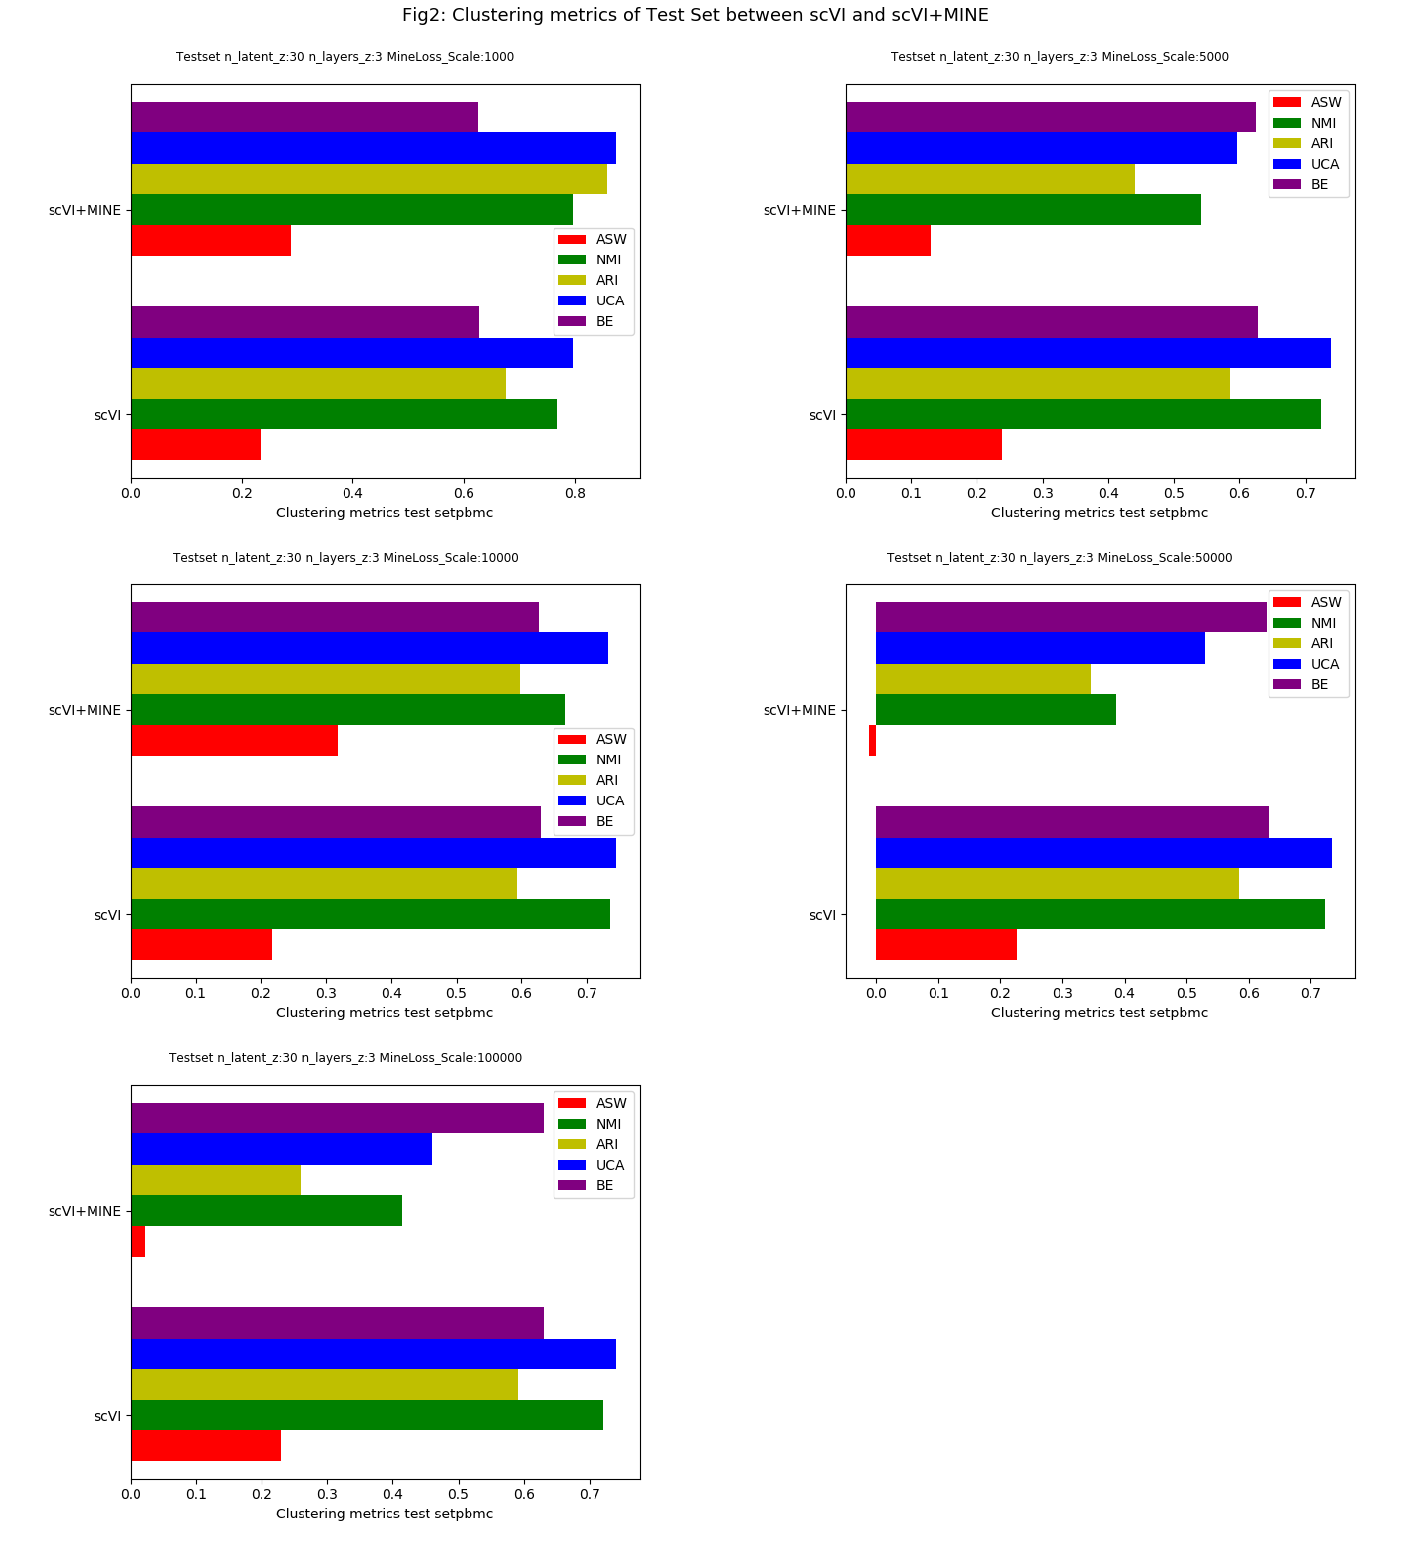

In [73]:
images = []
for MineLoss_Scale in MineLoss_Scales:
    img_path = 'result\\2019-05-01\\testset_clustering_metrics_pbmc_Hidden30_layers3_MineLossScale%s.png'%(MineLoss_Scale)
    images.append(mpimg.imread(img_path))

fig,ax = plt.subplots(3,2,figsize=(20,21))
fig.tight_layout()
columns = 2
for i, image in enumerate(images):
    ax[i//2,i-(i//2)*2] = plt.subplot(len(images) / columns + 1, columns, i + 1)
    ax[i//2,i-(i//2)*2].axis('off')
    ax[i//2,i-(i//2)*2].set_title('Testset n_latent_z:30 n_layers_z:3 MineLoss_Scale:%s'%(MineLoss_Scales[i]))
    plt.imshow(image)
fig.suptitle('Fig2: Clustering metrics of Test Set between scVI and scVI+MINE', y=1.03, fontsize=18, verticalalignment='top')
ax[-1,-1].axis('off')   

From Fig1 and Fig2 above, it seems that for n_latent_z=30, n_layers_z=3, when MineLoss_Scale=1000, scVI+MINE is better than scVI because of higher clustering metrics. However, there is a problem, when compare all the scVI in the five subplots in Fig1, it is discovered that UCA and ARI of scVI in the subplot MineLoss_Scale = 5000 is much larger than those of scVI in other subplots. However, MineLoss_Scale difference should not influence the clustering result in scVI. One of the reasons for the discrepancy could be the training sample for scVI in each subplot is different. However, this reason is ruled out after the original code in scVI is checked out. Check the code file D:/UMelb/PhD_Projects/Project1_Modify_SCVI/code/2019-05-01_Tune_Hyperparameter_For_MineNet.py, training and testing dataset is splitted by the UnsupervisedTrainer() function, which is defined in D:/UMelb/PhD_Projects/Project1_Modify_SCVI/scvi/inference/inference.py. The train_test() function in inference.py will do the splitting, which takes in a seed with default value to be zero. UnsupervisedTrainer inherits trainer class. train_test() function is defined in D:/UMelb/PhD_Projects/Project1_Modify_SCVI/scvi/inference/trainer.py.  Check train_test() function, as the seed remains 0 every time, the training sample and testing sample for scVI each time will remain the same.

Then another possibility is that scVI is not stable even when the training sample is the same. The reason could result from the initialization of the parameters in the networks, different initialization values could result in different optimization result. The other reason could be the reparametrization of z in the scVI method, according to the [tutorial_of_scVI](https://arxiv.org/abs/1606.05908). The paper titled [Deep_generative_modeling_for_single-cell_transcriptomics](https://www-nature-com.ezp.lib.unimelb.edu.au/articles/s41592-018-0229-2#Sec43) investigates the variability of scVI in supplementary figure 1.d due to different initialization of parameters.

Now that scVI is not stable, scVI+MINE is also not stable, it is not safe to say that scVI+MINE is better than scVI for n_latent_z=30, n_layers_z=3 and MineLoss_Scale=1000 when only one training sample is run. Therefore, we need to run 100 monte carlos. 

## 4.2 Batch and Cell Labels result of train set between scVI and scVI+MINE
For each row, left is scVI, right is scVI+MINE.

Text(0.5, 1, 'Fig3: Trainset tsne plots')

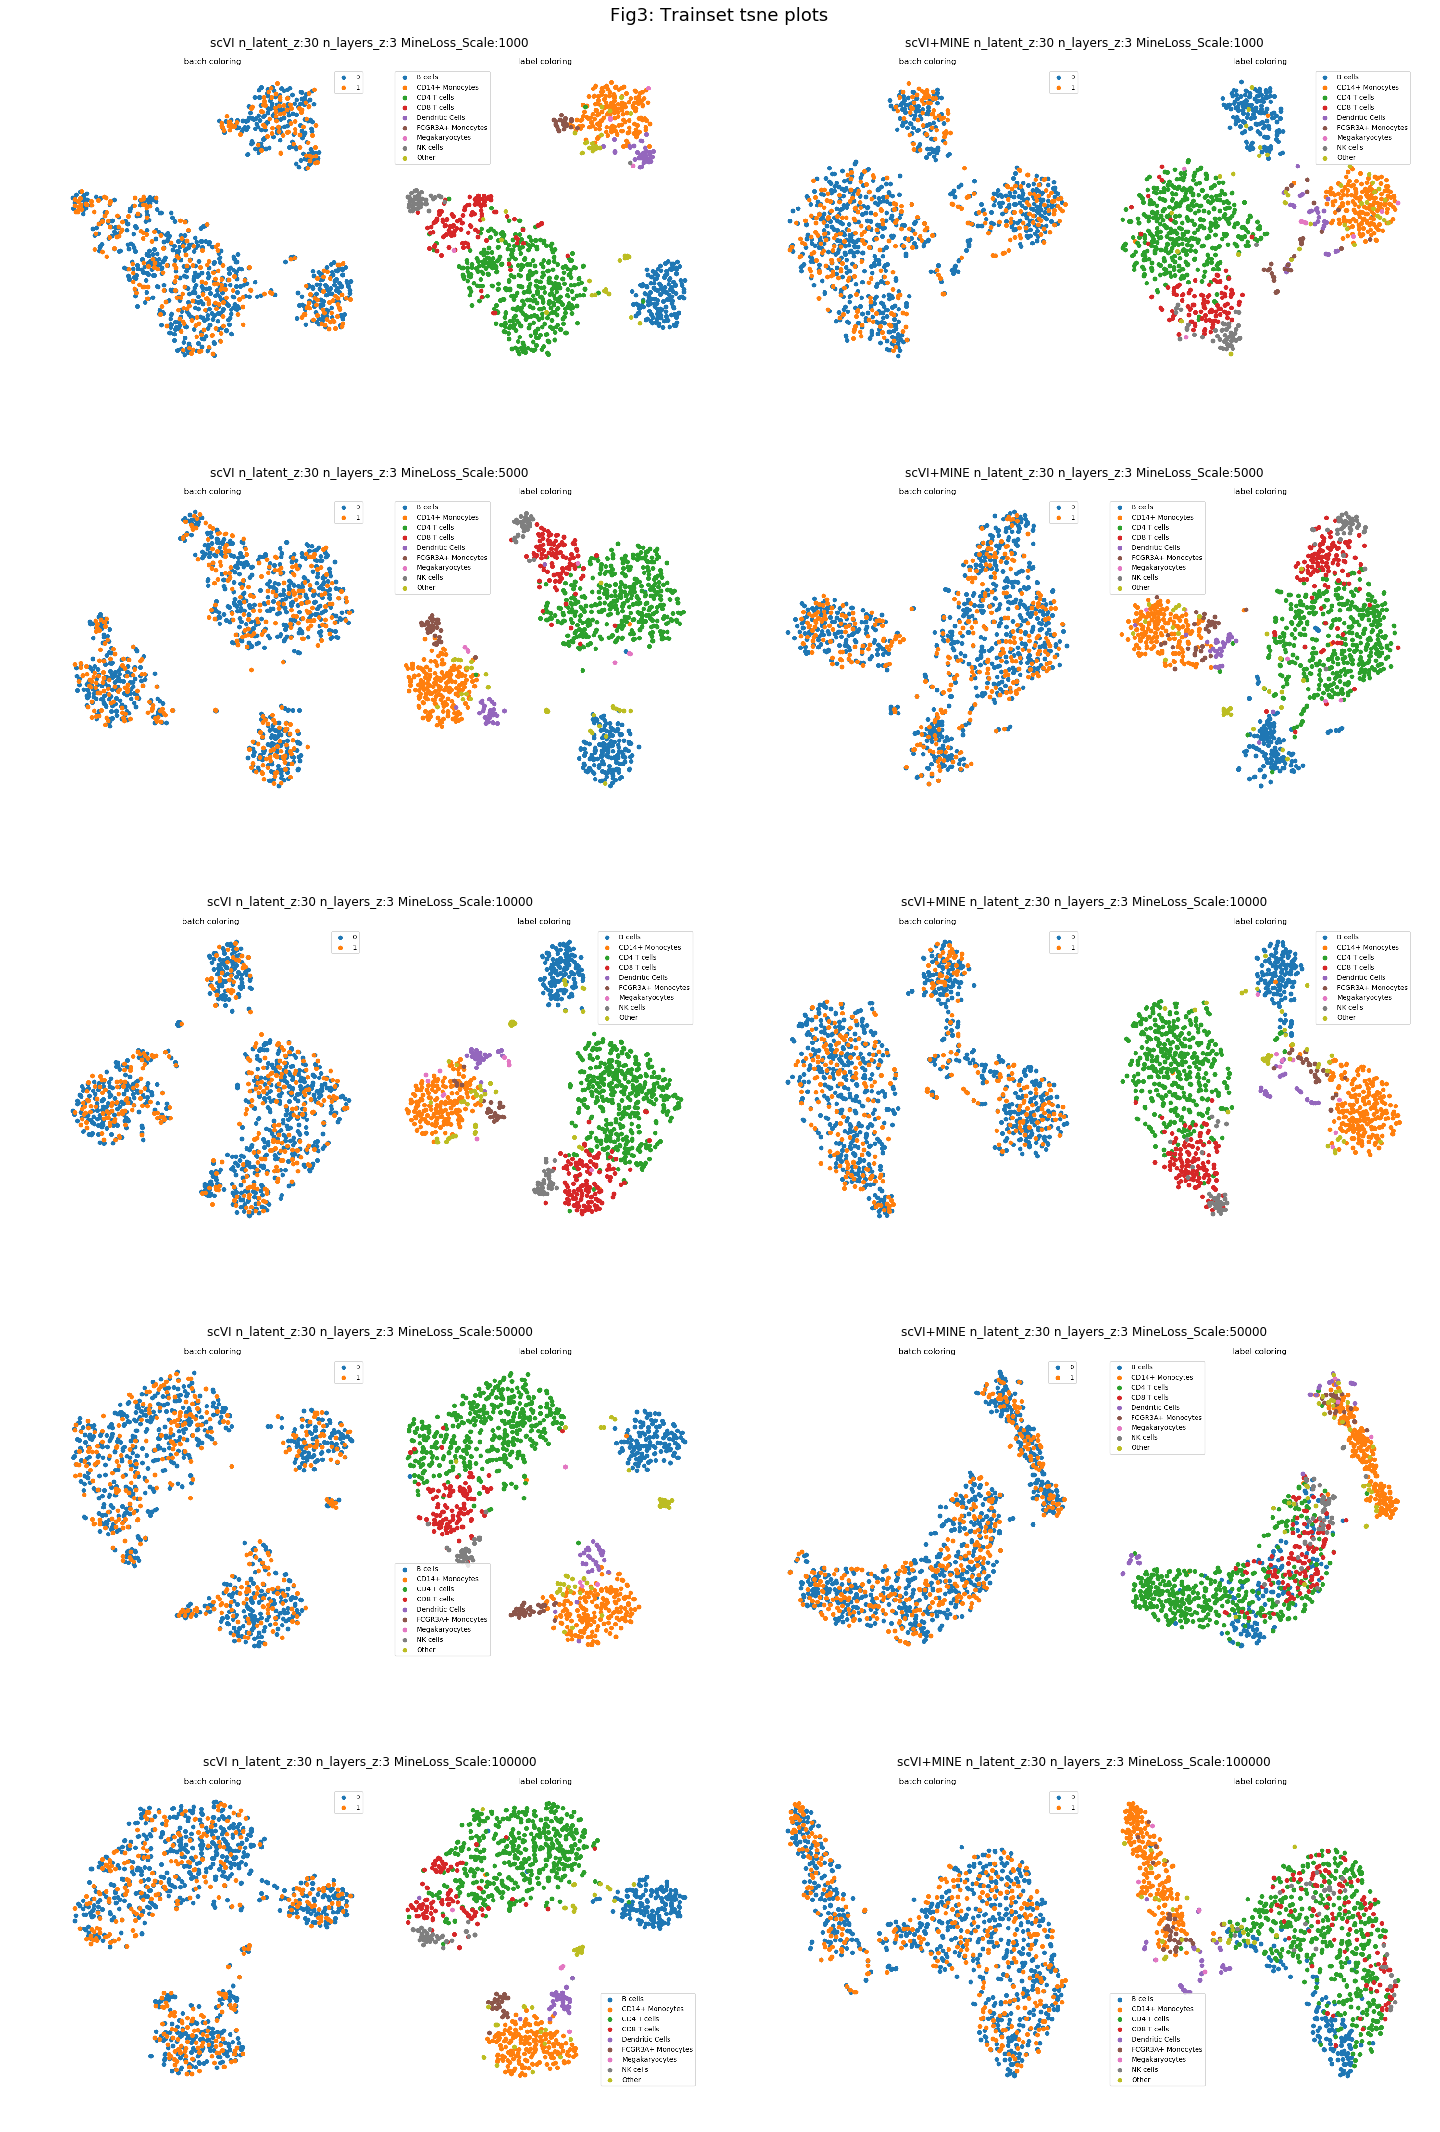

In [89]:
images = []
for MineLoss_Scale in MineLoss_Scales:
    img_path1 = 'result\\2019-05-01\\trainset_tsne_SCVI_pbmc_Hidden30_layers3_MineLossScale%s.png'%(MineLoss_Scale)
    img_path2 = 'result\\2019-05-01\\trainset_tsne_SCVI+MINE_pbmc_Hidden30_layers3_MineLossScale%s.png'%(MineLoss_Scale)
    images.append(mpimg.imread(img_path1))
    images.append(mpimg.imread(img_path2))

fig,ax = plt.subplots(5,2,figsize=(20,30))
fig.tight_layout()
columns = 2
for i, image in enumerate(images):
    ax[i//2,i-(i//2)*2] = plt.subplot(len(images) / columns, columns, i + 1)
    ax[i//2,i-(i//2)*2].axis('off')
    if (i+1)%2==1:
        ax[i//2,i-(i//2)*2].set_title('scVI n_latent_z:30 n_layers_z:3 MineLoss_Scale:%s'%(MineLoss_Scales[i//2]))
    else:
        ax[i//2,i-(i//2)*2].set_title('scVI+MINE n_latent_z:30 n_layers_z:3 MineLoss_Scale:%s'%(MineLoss_Scales[i//2]))
    plt.imshow(image)
fig.suptitle('Fig3: Trainset tsne plots', y=1, fontsize=18, verticalalignment='top') 

## 4.3 Batch and Cell Labels result of test set between scVI and scVI+MINE 
For each row, left is scVI, right is scVI+MINE.

Text(0.5, 1, 'Fig4: Testset tsne plots')

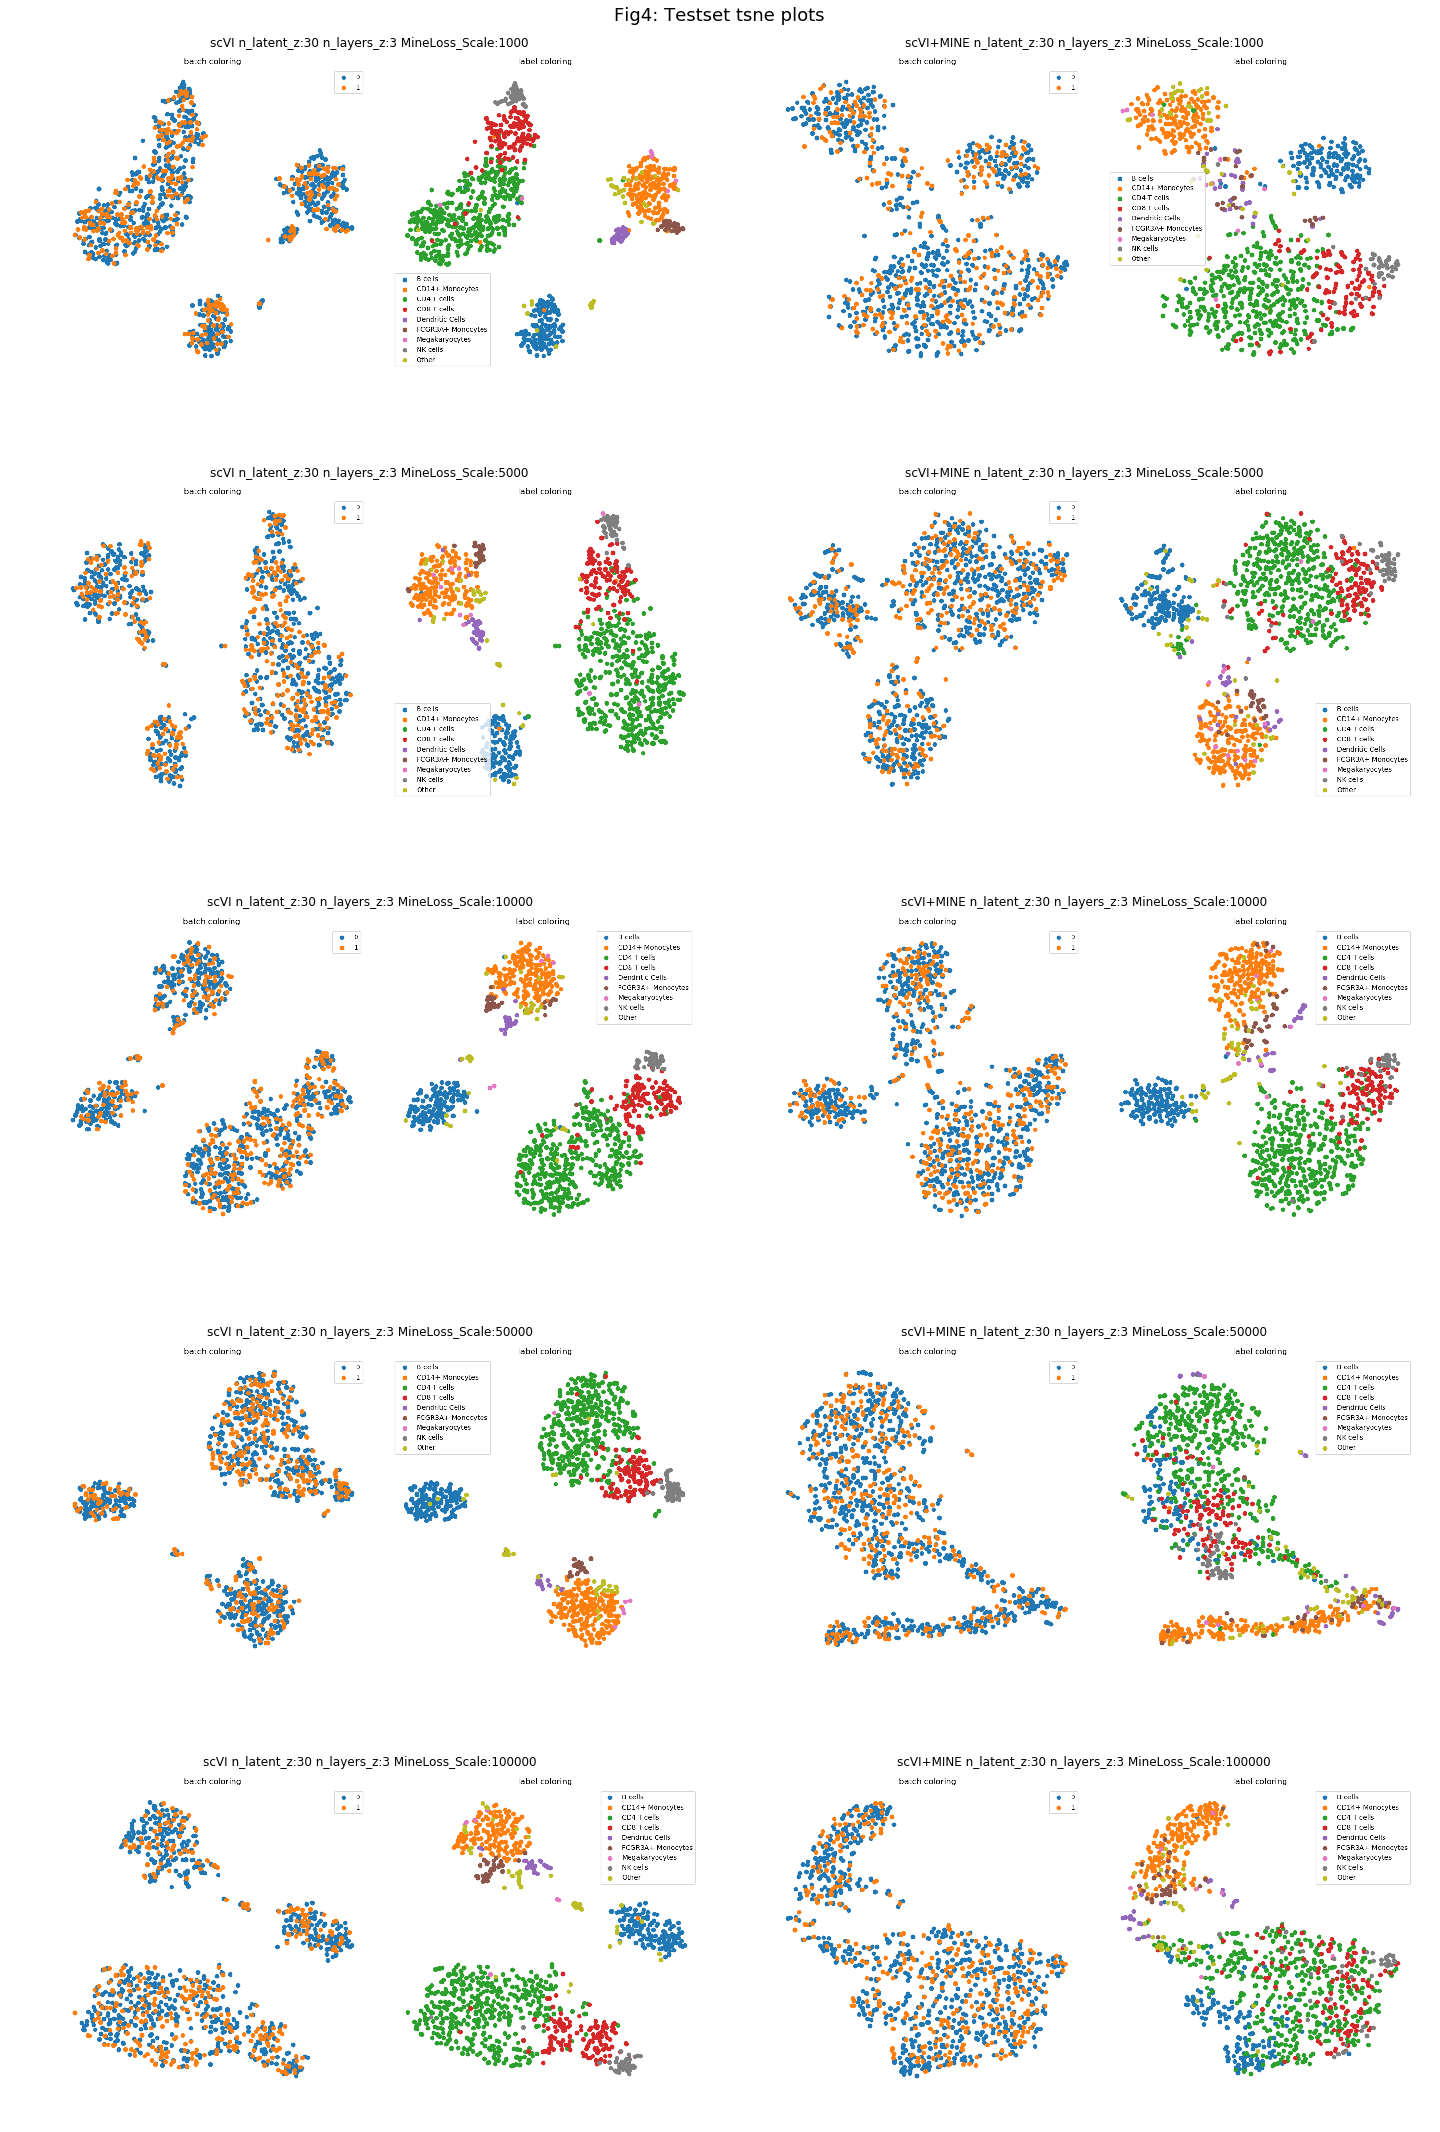

In [91]:
images = []
for MineLoss_Scale in MineLoss_Scales:
    img_path1 = 'result\\2019-05-01\\testset_tsne_SCVI_pbmc_Hidden30_layers3_MineLossScale%s.png'%(MineLoss_Scale)
    img_path2 = 'result\\2019-05-01\\testset_tsne_SCVI+MINE_pbmc_Hidden30_layers3_MineLossScale%s.png'%(MineLoss_Scale)
    images.append(mpimg.imread(img_path1))
    images.append(mpimg.imread(img_path2))

fig,ax = plt.subplots(5,2,figsize=(20,30))
fig.tight_layout()
columns = 2
for i, image in enumerate(images):
    ax[i//2,i-(i//2)*2] = plt.subplot(len(images) / columns, columns, i + 1)
    ax[i//2,i-(i//2)*2].axis('off')
    if (i+1)%2==1:
        ax[i//2,i-(i//2)*2].set_title('scVI n_latent_z:30 n_layers_z:3 MineLoss_Scale:%s'%(MineLoss_Scales[i//2]))
    else:
        ax[i//2,i-(i//2)*2].set_title('scVI+MINE n_latent_z:30 n_layers_z:3 MineLoss_Scale:%s'%(MineLoss_Scales[i//2]))
    plt.imshow(image)
fig.suptitle('Fig4: Testset tsne plots', y=1, fontsize=18, verticalalignment='top') 

From Fig1 and Fig2, when n_latent_z=30, n_layers_z=3, MineLoss_Scale=1000, for both train set and test set, at least for this 
run, scVI+MINE is better than scVI according to the clustering metrics. However, the corresponding tsne plots for both train set in Fig3 and test set in Fig4 do not show the same pattern, even opposite. In fact, the clustering result in tsne plots shows that scVI+MINE is worse than scVI. One reason could be tsne plots are not very accurate, after all it only shows two dimensions of latent vector z's variation (check tsne's paper, and say this sentence in a professional way). The other reason could be that the clustering metrics are not appropriate. 
<font color=red>Which one is correct or is there other explanation???????? Maybe know about manifold learning clustering metrics could help??</font>

## 4.4 tsne 
tsne is applied mainly in computer vision, and is introduced into computation biology due to single cell RNA seq problem research. <font color=red>susan talked something more here, what is it?</font>

## 4.5 
In reality, usually the batch effect in the dataset is unknown. The independence between batch and latent factor z is a more important problem than the independence between library size and latent factor z. <font color=red>Why???</font>. Heejung explained batch s is not included in z, but l is???. <font color=red>Make sure again.</font>

## 4.6 
Is deep learning only appropriate when dimension of input is at least 70? The answer from susan is no. Actually linear
regression, logistic regression etc can also be considered as a type of simple deep learning neural network. 
<font color=red>But how to consider linear regresion or logistic regression as deep learning neural network?Be clear about the details</font>

# 5.To Dos
## 5.1 
Establish a system so that everything about the project Project1_Modify_SCVI, including the background, the result, the code, the data, the lab meeting content, the references can be versioned controlled and shared, and can be accessed after many years later. Workflowr is a very good package to realize this, but only in R language. Jupyter Notebooks are not easy for github version control, although it can use python. Fortunately, there are some ways to overcome the problem of version control in Jupyter Notebook, please refer to this link: 
[How_to_Version_Control_Jupyter_Notebooks](https://nextjournal.com/schmudde/how-to-version-control-jupyter)

## 5.2
Because SCVI is not stable even when the sample of Pbmc_dataset fed into the neural network of SCVI remains constant, get 100 Monte Carlo samples. For each sample, run both SCVI and SCVI+MINE, get the average clustering metrics for the 100 Monte Carlos for both SCVI and SCVI+MINE, and then compare. In the raw result of tuning hyperparameters for MineNet (stored in D:/UMelb/PhD_Projects/Project1_Modify_SCVI/result/2019-05-01/), 20 grid points are run for the three hyperparameters. But here only one combination is chosen, because of the large computation time. n_latent_z=30, n_layers_z=3, MineLoss_Scale=1000 is chosen because it seems to work best among all the other combinations according to result of 2019-05-06(a link should be added here). 

## 5.3
Find real data set with obvious batch effect. Because the pbmc dataset used now do not have obvious batch effect. The dataset used in the paper [Harmonizing datasets with different composition of cell types.]() could be a resource. And another thing is to simulate data set with obvious batch effect from ZINB model.